## Download and Install Required Libraries

Github: [source codes](https://github.com/qubvel/segmentation_models.pytorch/blob/master/README.md)

In [ ]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=fb9a3fd1b8db2b85e655130015f38456c47c710f6d7f02e36daf7b1b52e789d5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=612a7c0d0333e5d05c0f8218bee00

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
!nvidia-smi

Mon Jun 19 07:56:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set Global Seed

In [ ]:
import random

random.seed(13204942)

## Mount Google Drive to access your data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/Ultrasound_project/'

### Data Preparation

In [ ]:
import cv2
import os
from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
TRAIN_IMG_DIR = root_path + "HC18_UNet_orig/train_images/"
TRAIN_MASK_DIR = root_path + "HC18_UNet_orig/train_masks/"

VAL_IMG_DIR = root_path + "HC18_UNet_orig/val_images/"
VAL_MASK_DIR = root_path + "HC18_UNet_orig/val_masks/"

In [ ]:
# process original mask to binary mask
def preprocess_mask(mask):
  #mask = mask.astype(np.float32)
  #mask[mask == 2.0] = 0.0
  #mask[(mask == 1.0) | (mask == 3.0)] = 1.0

  # we need to use sigmoid
  mask[mask == 255.0] = 1.0

  mask = np.stack([mask], axis=-1).astype('float')
  return mask

In [ ]:
# Dataset class
class HeadDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index].replace(".png", "_Annotation.png"))
    #image = np.array(Image.open(img_path).convert("RGB"))
    #mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED).astype('float32')
    #mask = preprocess_mask(mask)
    mask[mask == 255.0] = 1.0

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

In [ ]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(10, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
# Lets look at data we have

dataset = HeadDataset(
    image_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=None,
    )

In [ ]:
index = random.sample(range(1, len(dataset)), 2)
print(index)

[748, 116]


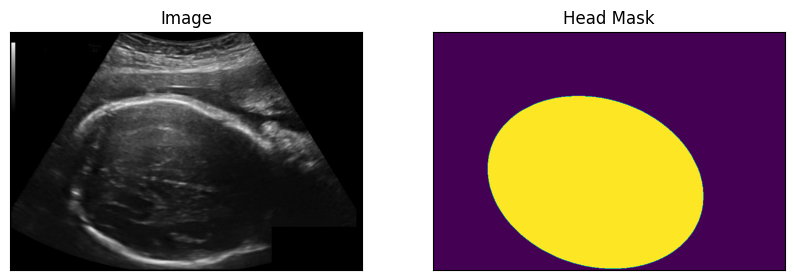

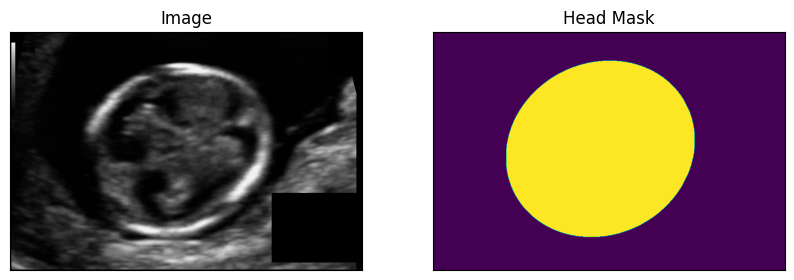

In [ ]:
for i in index:
  image, mask = dataset[i] # get some sample
  visualize(
      image=image,
      head_mask=mask.squeeze(),
  )

In [ ]:
print(image.shape, mask.shape)

(540, 800, 3) (540, 800)


In [ ]:
# get Train/Validation DataLoaders from Dataset class
def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = HeadDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = HeadDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

## Build Model

We are using an existing Pytorch library, Segmentation Models (SMP), with Neural Networks for Image
Segmentation. The official library document is [here](https://smp.readthedocs.io/).

P. Iakubovskii, “Segmentation models pytorch,” 2019.

*@misc{Iakubovskii:2019,
  Author = {Pavel Iakubovskii},
  Title = {Segmentation Models Pytorch},
  Year = {2019},
  Publisher = {GitHub},
  Journal = {GitHub repository},
  Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
}*

**Avaliable architectures:**
 - Unet [[paper](https://arxiv.org/abs/1505.04597)] [[docs](https://smp.readthedocs.io/en/latest/models.html#unet)]
 - Unet++ [[paper](https://arxiv.org/pdf/1807.10165.pdf)] [[docs](https://smp.readthedocs.io/en/latest/models.html#id2)]
 - MAnet [[paper](https://ieeexplore.ieee.org/abstract/document/9201310)] [[docs](https://smp.readthedocs.io/en/latest/models.html#manet)]
 - Linknet [[paper](https://arxiv.org/abs/1707.03718)] [[docs](https://smp.readthedocs.io/en/latest/models.html#linknet)]
 - FPN [[paper](http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf)] [[docs](https://smp.readthedocs.io/en/latest/models.html#fpn)]
 - PSPNet [[paper](https://arxiv.org/abs/1612.01105)] [[docs](https://smp.readthedocs.io/en/latest/models.html#pspnet)]
 - PAN [[paper](https://arxiv.org/abs/1805.10180)] [[docs](https://smp.readthedocs.io/en/latest/models.html#pan)]
 - DeepLabV3 [[paper](https://arxiv.org/abs/1706.05587)] [[docs](https://smp.readthedocs.io/en/latest/models.html#deeplabv3)]
 - DeepLabV3+ [[paper](https://arxiv.org/abs/1802.02611)] [[docs](https://smp.readthedocs.io/en/latest/models.html#id9)]

**Available Encoders:**
The following is a list of supported encoders in the SMP library. The selected encoder and its pre-trained weights (encoder_name and encoder_weights parameters) are shown as below.

* ResNet

| Encoder   | Weights               | Params, M |
| --------- | --------------------- | --------- |
| resnet18  | imagenet / ssl / swsl | 11M       |
| resnet50  | imagenet / ssl / swsl | 23M       |
| resnet101 | imagenet              | 42M       |
| resnet152 | imagenet              | 58M       |

* Densenet

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|densenet121                     |imagenet                        |6M                              |
|densenet169                     |imagenet                        |12M                             |
|densenet201                     |imagenet                        |18M                             |
|densenet161                     |imagenet                        |26M                             |

* Inception

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|inceptionresnetv2               |imagenet /  imagenet+background |54M                             |
|inceptionv4                     |imagenet /  imagenet+background |41M                             |
|xception                        |imagenet                        |22M                             |

* Mobilenet

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|mobilenet_v2                    |imagenet                        |2M                              |

* VGG

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|vgg11                           |imagenet                        |9M                              |
|vgg13                           |imagenet                        |9M                              |
|vgg16                           |imagenet                        |14M                             |
|vgg19                           |imagenet                        |20M                             |

In [ ]:
import os
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [ ]:
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics

Set pre-trained encoders. **Choose one ENCODER from above encoders list to build your model !**

In [ ]:
# if encoder needs to be frozen, set below flag = True
freeze_flag = True

In [ ]:
#ENCODER = 'resnet18'
#ENCODER = 'resnet50'
#ENCODER = 'resnet101'
#ENCODER = 'resnet152'

ENCODER = 'mobilenet_v2'

#ENCODER = 'densenet121'
#ENCODER = 'densenet169'
#ENCODER = 'densenet201'

#ENCODER = 'inceptionresnetv2'
#ENCODER = 'inceptionv4'
#ENCODER = 'xception'

#ENCODER = 'efficientnet-b0'
#ENCODER = 'efficientnet-b1'
#ENCODER = 'efficientnet-b3'
#ENCODER = 'efficientnet-b4'
#ENCODER = 'efficientnet-b7'

#ENCODER = 'vgg11'
#ENCODER = 'vgg13'
#ENCODER = 'vgg16'
#ENCODER = 'vgg19'

#Mix Visual Transformer
#ENCODER = 'mit_b0'
#ENCODER = 'mit_b2'
#ENCODER = 'mit_b4'

ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['head'] # a binary classification problem to classify each pixel into one of the two classes, Class 1: Head or Class 2: Not Head
#ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
ACTIVATION = None # could be None for logits or 'softmax2d' for multiclass segmentation

AUX_PARAMS=dict(
    pooling='max',           # one of 'avg', 'max'
    activation='sigmoid',    # activation function, default is None
    classes=1,               # define number of output labels
)

**Select one of below architectures to build your model !**

Build a deep learning architecture using library segmentation_models_pytorch, and then load pre-trained CNN to encoders inside the architecture.

#### U-Net

<img src=https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png width="640">

In [ ]:
# create segmentation model with pretrained encoder
unet_model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    decoder_attention_type=None,
    classes=len(CLASSES),
    activation=ACTIVATION,
    aux_params=None
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
model = unet_model

if freeze_flag:
  model_name = f'unet_frozen_{ENCODER}'
else:
  model_name = f'unet_{ENCODER}'

In [ ]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [ ]:
model.classification_head = None

In [ ]:
print(model)

**Freeze Decoder layers partially**

In [ ]:

for param in model.encoder.parameters():
  param.requires_grad = False


In [ ]:
if freeze_flag:
  # freeze all layers except the bottleneck
  '''
  for param in model.encoder.model.blocks[0].parameters():
    param.requires_grad = False

  for param in model.encoder.model.blocks[1].parameters():
    param.requires_grad = False

  for param in model.encoder.model.blocks[2].parameters():
    param.requires_grad = False

  for param in model.encoder.model.blocks[3].parameters():
    param.requires_grad = False

  for param in model.encoder.model.blocks[4].parameters():
    param.requires_grad = False
  '''
  '''
  for param in model.decoder.blocks[0].parameters():
    param.requires_grad = False

  for param in model.decoder.blocks[1].parameters():
    param.requires_grad = False

  for param in model.decoder.blocks[2].parameters():
    param.requires_grad = False

  for param in model.decoder.blocks[3].parameters():
    param.requires_grad = False

  for param in model.decoder.blocks[4].parameters():
    param.requires_grad = False

  for param in model.segmentation_head.parameters():
    param.requires_grad = False
  '''

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)

In [ ]:
from torchsummary import summary

print(summary(model, (3, 512, 512)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
             ReLU6-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
             ReLU6-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 16, 256, 256]             512
       BatchNorm2d-8         [-1, 16, 256, 256]              32
  InvertedResidual-9         [-1, 16, 256, 256]               0
           Conv2d-10         [-1, 96, 256, 256]           1,536
      BatchNorm2d-11         [-1, 96, 256, 256]             192
            ReLU6-12         [-1, 96, 256, 256]               0
           Conv2d-13         [-1, 96, 128, 128]             864
      BatchNorm2d-14         [-1, 96, 1

#### DeepLabV3+

<img src=https://production-media.paperswithcode.com/models/Screen_Shot_2021-02-21_at_10.34.37_AM_kvOFts0.png width="640">

In [ ]:
# create segmentation model with pretrained encoder
dl3plus_model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    aux_params=AUX_PARAMS
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
model = dl3plus_model

if freeze_flag:
  model_name = f'dl3plus_frozen_{ENCODER}'
else:
  model_name = f'dl3plus_{ENCODER}'

In [ ]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [ ]:
print(model)

DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSa

#### FPN

<img src=https://user-images.githubusercontent.com/527241/42149076-00cf1d80-7dd5-11e8-94c6-5ac0e79d3b77.png width="640">

In [ ]:
# create segmentation model with pretrained encoder
fpn_model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    aux_params=AUX_PARAMS
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
model = fpn_model

if freeze_flag:
  model_name = f'fpn_frozen_{ENCODER}'
else:
  model_name = f'fpn_{ENCODER}'

In [ ]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [ ]:
print(model)

FPN(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=32, ou

#### PAN

<img src=https://raw.githubusercontent.com/SHI-Labs/Pyramid-Attention-Networks/master/Figs/block.png width="640">


In [ ]:
# create segmentation model with pretrained encoder
pan_model = smp.PAN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    aux_params=AUX_PARAMS
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
model = pan_model

if freeze_flag:
  model_name = f'pan_frozen_{ENCODER}'
else:
  model_name = f'pan_{ENCODER}'

In [ ]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [ ]:
model.classification_head = None

In [ ]:
print(model)

PAN(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1,

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)

In [ ]:
from torchsummary import summary

print(summary(model, (3, 512, 512)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
             ReLU6-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
             ReLU6-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 16, 256, 256]             512
       BatchNorm2d-8         [-1, 16, 256, 256]              32
  InvertedResidual-9         [-1, 16, 256, 256]               0
           Conv2d-10         [-1, 96, 256, 256]           1,536
      BatchNorm2d-11         [-1, 96, 256, 256]             192
            ReLU6-12         [-1, 96, 256, 256]               0
           Conv2d-13         [-1, 96, 128, 128]             864
      BatchNorm2d-14         [-1, 96, 1

#### LinkNet

<img src=https://www.researchgate.net/profile/Shadrokh-Samavi/publication/327835729/figure/fig2/AS:674224633020428@1537759087600/a-LinkNet-architecture-b-convolutional-modules-in-encoder-block-c-convolutional.ppm width="640">

In [ ]:
# create segmentation model with pretrained encoder
linknet_model = smp.Linknet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    aux_params=AUX_PARAMS
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
model = linknet_model

if freeze_flag:
  model_name = f'linknet_frozen_{ENCODER}'
else:
  model_name = f'linknet_{ENCODER}'

In [ ]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [ ]:
print(model)

Linknet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadd

#### MAnet

![](https://drive.google.com/uc?id=1R-JYdfNTWLvTy69LF9d46c960RYnpSf9)
(a) overall architecture
![](https://drive.google.com/uc?id=1xWFUhZXQCy7KiOXt2einWFGSLeB1ubSO)
(b) Position-wise Attention Block (PAB)
![](https://drive.google.com/uc?id=17AIOolOwpu9_qsclzXGyi3inJr1C2I2b)
(c) The Multi-scale Fusion Attention Block (MFAB)



In [ ]:
# create segmentation model with pretrained encoder
manet_model = smp.MAnet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    aux_params=AUX_PARAMS
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
model = manet_model

if freeze_flag:
  model_name = f'manet_frozen_{ENCODER}'
else:
  model_name = f'manet_{ENCODER}'

In [ ]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [ ]:
print(model)

MAnet(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=32, 

## Training Model

In [ ]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 10
NUM_EPOCHS = 20 # 5 warm-up
NUM_WORKERS = 2
# UNet DeepLab3+
#IMAGE_HEIGHT = 240  # 540 originally
#IMAGE_WIDTH = 240  # 800 originally
# FPN
IMAGE_HEIGHT = 512  # 540 originally
IMAGE_WIDTH = 512  # 800 originally

PIN_MEMORY = True
LOAD_MODEL = False

In [ ]:
DEVICE

'cuda'

#### Set-up Data Loader

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=25, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

In [ ]:
# split train, validation
full_dataset = HeadDataset(
    image_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=train_transform,
    )

In [ ]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_dataset, [train_size, val_size])

### Split Training Set

In [ ]:
len(train_ds)

799

In [ ]:
#split_train_size_10 = int(0.1 * len(train_ds))
#split_train_size_30 = int(0.3 * len(train_ds))
split_train_size_50 = int(0.5 * len(train_ds))

#### Save Dataset

In [ ]:
save_path = root_path + 'train_data_split/'

In [ ]:
#train_length = split_train_size_10
#train_length = split_train_size_30
train_length = split_train_size_50

In [ ]:
remaining_size = len(train_ds) - train_length
train_ds, _ = torch.utils.data.random_split(train_ds, [train_length, remaining_size])

In [ ]:
#torch.save(train_ds, save_path + 'split_train_size_10.pt')
#torch.save(train_ds, save_path + 'split_train_size_30.pt')
torch.save(train_ds, save_path + 'split_train_size_50.pt')

#### Load Dataset

In [ ]:
save_path + 'split_train_size_50.pt'

'/content/drive/MyDrive/Ultrasound_project/train_data_split/split_train_size_50.pt'

In [ ]:
#train_ds = torch.load(save_path + 'split_train_size_10.pt')
#train_ds = torch.load(save_path + 'split_train_size_30.pt')
train_ds = torch.load(save_path + 'split_train_size_50.pt')

In [ ]:
print(f'The lenght of train dataset: {len(train_ds)}')

The lenght of train dataset: 399


#### Start DataLoader

In [ ]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
print(len(train_loader))
print(len(val_loader))

40
20


In [ ]:
'''
train_loader, val_loader = get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms,
    NUM_WORKERS,
    PIN_MEMORY,
    )
'''

#### Create a Function for Training

In [ ]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader)
  losses = []

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    # forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      #loss = loss_fn(predictions[0], targets)
      loss = loss_fn(predictions, targets)
      losses.append(loss.item())

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())

  return losses #loss.item()

In [ ]:
def check_accuracy(loader, model, loss_fn, pix_acc, dice, iou, device="cuda", is_train=True):
    num_correct = 0
    num_pixels = 0
    dice_score = 0.0
    iou_score = 0.0
    losses = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            prediction = model(x)
            loss = loss_fn(prediction, y.float())
            losses.append(loss.item())

            #preds = preds[0]
            preds = torch.sigmoid(prediction)
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
                )
            iou_score += (preds * y).sum() / (
                (preds + y).sum() - (preds * y).sum() + 1e-8
                )

    print(f"Got validation loss: {np.mean(losses):.6f}")

    p_acc = num_correct/num_pixels*100
    print(f"Got {num_correct}/{num_pixels} with acc {p_acc:.6f}")
    pix_acc.append(p_acc.item())

    d_score = dice_score / len(loader)
    print(f"Dice score: {d_score:.7f}")
    dice.append(d_score.item())

    iou_score = iou_score / len(loader)
    print(f"mIoU: {iou_score:.7f}")
    iou.append(iou_score.item())

    if is_train:
      model.train()

    return pix_acc, dice, iou

#### Start Training

In [ ]:
model = model.to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
best_loss = 1.0

pix_acc = []
dice = []
miou = []

for epoch in range(NUM_EPOCHS):
  print(f"{epoch}:")
  current_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
  print(f"Got training loss: {np.mean(current_loss):.6f}")

  # check accuracy
  pix_acc, dice_score, m_iou = check_accuracy(val_loader, model, loss_fn, pix_acc, dice, miou, device=DEVICE)

  # print some examples to a folder
  #save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=DEVICE)

0:


100%|██████████| 40/40 [01:26<00:00,  2.17s/it, loss=0.365]

Got training loss: 0.466777


Got validation loss: 0.361344
Got 46905950/52428800 with acc 89.466003
Dice score: 0.8314931
mIoU: 0.7120533
1:


100%|██████████| 40/40 [00:11<00:00,  3.34it/s, loss=0.256]

Got training loss: 0.299628


Got validation loss: 0.262717
Got 49195297/52428800 with acc 93.832573
Dice score: 0.8965855
mIoU: 0.8131387
2:


100%|██████████| 40/40 [00:12<00:00,  3.32it/s, loss=0.208]

Got training loss: 0.240409


Got validation loss: 0.216661
Got 49414128/52428800 with acc 94.249969
Dice score: 0.9066723
mIoU: 0.8296999
3:


100%|██████████| 40/40 [00:12<00:00,  3.33it/s, loss=0.185]

Got training loss: 0.204406


Got validation loss: 0.183914
Got 49858829/52428800 with acc 95.098167
Dice score: 0.9210402
mIoU: 0.8540030
4:


100%|██████████| 40/40 [00:11<00:00,  3.50it/s, loss=0.165]

Got training loss: 0.170281


Got validation loss: 0.169214
Got 49987756/52428800 with acc 95.344078
Dice score: 0.9246088
mIoU: 0.8601276
5:


100%|██████████| 40/40 [00:10<00:00,  3.78it/s, loss=0.164]

Got training loss: 0.161024


Got validation loss: 0.148979
Got 50257249/52428800 with acc 95.858093
Dice score: 0.9314678
mIoU: 0.8721430
6:


100%|██████████| 40/40 [00:12<00:00,  3.32it/s, loss=0.133]

Got training loss: 0.139817


Got validation loss: 0.131715
Got 50557714/52428800 with acc 96.431175
Dice score: 0.9409076
mIoU: 0.8886329
7:


100%|██████████| 40/40 [00:12<00:00,  3.29it/s, loss=0.118]

Got training loss: 0.124720


Got validation loss: 0.129991
Got 50470477/52428800 with acc 96.264793
Dice score: 0.9373904
mIoU: 0.8824973
8:


100%|██████████| 40/40 [00:11<00:00,  3.35it/s, loss=0.103]

Got training loss: 0.116189


Got validation loss: 0.124307
Got 50430993/52428800 with acc 96.189484
Dice score: 0.9380686
mIoU: 0.8836325
9:


100%|██████████| 40/40 [00:11<00:00,  3.47it/s, loss=0.0932]

Got training loss: 0.109316


Got validation loss: 0.112604
Got 50620097/52428800 with acc 96.550163
Dice score: 0.9425535
mIoU: 0.8916873
10:


100%|██████████| 40/40 [00:10<00:00,  3.70it/s, loss=0.0921]

Got training loss: 0.102014


Got validation loss: 0.107223
Got 50696797/52428800 with acc 96.696457
Dice score: 0.9451796
mIoU: 0.8962511
11:


100%|██████████| 40/40 [00:13<00:00,  3.04it/s, loss=0.0911]

Got training loss: 0.095394


Got validation loss: 0.101556
Got 50748686/52428800 with acc 96.795441
Dice score: 0.9466028
mIoU: 0.8988871
12:


100%|██████████| 40/40 [00:11<00:00,  3.36it/s, loss=0.0986]

Got training loss: 0.093173


Got validation loss: 0.096795
Got 50835287/52428800 with acc 96.960617
Dice score: 0.9489541
mIoU: 0.9032373
13:


100%|██████████| 40/40 [00:11<00:00,  3.37it/s, loss=0.0819]

Got training loss: 0.085499


Got validation loss: 0.096513
Got 50767079/52428800 with acc 96.830521
Dice score: 0.9466209
mIoU: 0.8989712
14:


100%|██████████| 40/40 [00:11<00:00,  3.53it/s, loss=0.0866]

Got training loss: 0.090067


Got validation loss: 0.097694
Got 50713109/52428800 with acc 96.727577
Dice score: 0.9451076
mIoU: 0.8962302
15:


100%|██████████| 40/40 [00:10<00:00,  3.69it/s, loss=0.066]

Got training loss: 0.081067


Got validation loss: 0.089479
Got 50864901/52428800 with acc 97.017097
Dice score: 0.9497118
mIoU: 0.9045265
16:


100%|██████████| 40/40 [00:11<00:00,  3.37it/s, loss=0.0645]

Got training loss: 0.074766


Got validation loss: 0.089413
Got 50847016/52428800 with acc 96.982986
Dice score: 0.9496965
mIoU: 0.9045880
17:


100%|██████████| 40/40 [00:12<00:00,  3.29it/s, loss=0.0624]

Got training loss: 0.072143


Got validation loss: 0.085272
Got 50899239/52428800 with acc 97.082588
Dice score: 0.9514001
mIoU: 0.9075449
18:


100%|██████████| 40/40 [00:12<00:00,  3.23it/s, loss=0.065]

Got training loss: 0.072885


Got validation loss: 0.082651
Got 50894033/52428800 with acc 97.072662
Dice score: 0.9518467
mIoU: 0.9082063
19:


100%|██████████| 40/40 [00:11<00:00,  3.38it/s, loss=0.0778]

Got training loss: 0.069085


Got validation loss: 0.082868
Got 50902548/52428800 with acc 97.088905
Dice score: 0.9518451
mIoU: 0.9083309


Calculate average Pixel Accuracy:

In [ ]:
np.round(np.mean(pix_acc[5:]), 4) # without warm-up

97.6515

In [ ]:
np.round(np.std(pix_acc[5:]), 6) # without warm-up

0.544584

Calculate average Dice Score:

In [ ]:
np.round(np.mean(dice_score[5:]), 6) # without warm-up

0.961309

In [ ]:
np.round(np.std(dice_score[5:]), 6) # without warm-up

0.009576

Calculate average IoU:

In [ ]:
np.round(np.mean(m_iou[5:]), 6) # without warm-up

0.925734

In [ ]:
np.round(np.std(m_iou[5:]), 6) # without warm-up

0.017618

#### Examine model layers and parameters

In [ ]:
# calculate total parameters of the model
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print (f"{sum(p.numel() for p in model.parameters()):,}")

6,628,945


In [ ]:
para_count = count_parameters(model)
print (f"{para_count:,}")

4,405,073


In [ ]:
from torchsummary import summary

print(summary(model, (3, IMAGE_HEIGHT, IMAGE_WIDTH)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
             ReLU6-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
             ReLU6-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 16, 256, 256]             512
       BatchNorm2d-8         [-1, 16, 256, 256]              32
  InvertedResidual-9         [-1, 16, 256, 256]               0
           Conv2d-10         [-1, 96, 256, 256]           1,536
      BatchNorm2d-11         [-1, 96, 256, 256]             192
            ReLU6-12         [-1, 96, 256, 256]               0
           Conv2d-13         [-1, 96, 128, 128]             864
      BatchNorm2d-14         [-1, 96, 1

#### Save Model to G-Drive

In [ ]:
save_flag = True

In [ ]:
# set path to save
save_path = root_path + f'Saved_models/{ENCODER}/'
save_path

'/content/drive/MyDrive/Ultrasound_project/Saved_models/mobilenet_v2/'

In [ ]:
def save_checkpoint(state, save_path, filename):
    print("=> Saving checkpoint")
    filepath = save_path + filename
    torch.save(state, filepath)

In [ ]:
if save_flag:
  checkpoint = {
      "state_dict": model.state_dict(),
      "optimizer":optimizer.state_dict(),
      }
  save_checkpoint(checkpoint, save_path, f"{model_name}_19062023_50percent_model.pth.tar")
  print(f"{save_path}{model_name}_19062023_50percent_model.pth.tar")

=> Saving checkpoint
/content/drive/MyDrive/Ultrasound_project/Saved_models/mobilenet_v2/unet_frozen_mobilenet_v2_19062023_50percent_model.pth.tar


## Evaluation on Test Set

In [ ]:
TEST_HC18_IMG_DIR = root_path + "HC18_UNet_orig/HC18_test/"
TEST_HC18_MASK_DIR = root_path + "HC18_UNet_orig/HC18_test_masks/"
TEST_FPZ_IMG_DIR = root_path + "HC18_UNet_orig/SpanishHC_test/"
TEST_FPZ_MASK_DIR = root_path + "HC18_UNet_orig/SpanishHC_test_masks/"

In [ ]:
# load saved models
def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

In [ ]:
test_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

In [ ]:
test_hc18_ds = HeadDataset(
    image_dir=TEST_HC18_IMG_DIR,
    mask_dir=TEST_HC18_MASK_DIR,
    transform=test_transforms,
)

test_hc18_loader = DataLoader(
    test_hc18_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

test_fpz_ds = HeadDataset(
    image_dir=TEST_FPZ_IMG_DIR,
    mask_dir=TEST_FPZ_MASK_DIR,
    transform=test_transforms,
)

test_fpz_loader = DataLoader(
    test_fpz_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
checkpoint_name = save_path + f"{model_name}_19062023_model.pth.tar"
checkpoint_name

'/content/drive/MyDrive/Ultrasound_project/Saved_models/mobilenet_v2/unet_frozen_mobilenet_v2_02062023_model.pth.tar'

In [ ]:
LOAD_MODEL = False

In [ ]:
if LOAD_MODEL:
  load_checkpoint(torch.load(checkpoint_name), model)

=> Loading checkpoint


In [ ]:
if torch.cuda.is_available():
    model.cuda()

### Fetal Head

**HC18 Test Dataset**

In [ ]:
test_hc18_pix_acc = []
test_hc18_dice_scores = []
test_hc18_miou = []

# check accuracy
check_accuracy(test_hc18_loader,
               model,
               loss_fn,
               test_hc18_pix_acc, test_hc18_dice_scores, test_hc18_miou,
               device=DEVICE,
               is_train=False)

Got validation loss: 0.078877
Got 7658312/7864320 with acc 97.380478
Dice score: 0.9566115
mIoU: 0.9169073


([97.38047790527344], [0.9566115140914917], [0.9169072508811951])

**NOTE: If the above code block shows AttributeError like the below one, please initialize the model and load weights from saved checkpoint again.**

```
/usr/local/lib/python3.9/dist-packages/torchsummary/torchsummary.py in hook(module, input, output)
     17             m_key = "%s-%i" % (class_name, module_idx + 1)
     18             summary[m_key] = OrderedDict()
---> 19             summary[m_key]["input_shape"] = list(input[0].size())
     20             summary[m_key]["input_shape"][0] = batch_size
     21             if isinstance(output, (list, tuple)):

AttributeError: 'list' object has no attribute 'size'
```

**Spanish Test Dataset**

In [ ]:
test_fpz_pix_acc = []
test_fpz_dice_scores = []
test_fpz_miou = []

# check accuracy
check_accuracy(test_fpz_loader,
               model,
               test_fpz_pix_acc, test_fpz_dice_scores, test_fpz_miou,
               device=DEVICE,
               is_train=False)

Got 1912588/1966080 with acc 97.279266
Dice score: 0.9573686
mIoU: 0.9182239


([97.27926635742188], [0.9573686122894287], [0.9182238578796387])

### Fetal Abdomen

**Spanish Test Dataset**

In [ ]:
# load abdomen images from folder
TEST_FPZ_IMG_DIR = root_path + "HC18_UNet_orig/SpanishAbdomen_test/"
TEST_FPZ_MASK_DIR = root_path + "HC18_UNet_orig/SpanishAbdomen_test_masks/"

In [ ]:
# re-create dataloader
test_fpz_ds = HeadDataset(
    image_dir=TEST_FPZ_IMG_DIR,
    mask_dir=TEST_FPZ_MASK_DIR,
    transform=test_transforms,
)

test_fpz_loader = DataLoader(
    test_fpz_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
test_fpz_pix_acc = []
test_fpz_dice_scores = []
test_fpz_miou = []

# check accuracy
check_accuracy(test_fpz_loader,
               model,
               test_fpz_pix_acc, test_fpz_dice_scores, test_fpz_miou,
               device=DEVICE,
               is_train=False)

Got 1796764/1966080 with acc 91.388145
Dice score: 0.8212875
mIoU: 0.6969792


([91.38814544677734], [0.8212874531745911], [0.6969792246818542])

### Fetal Femur

**Spanish Test Dataset**

In [ ]:
# load abdomen images from folder
TEST_FPZ_IMG_DIR = root_path + "HC18_UNet_orig/SpanishFemur_test/"
TEST_FPZ_MASK_DIR = root_path + "HC18_UNet_orig/SpanishFemur_test_masks/"

In [ ]:
# re-create dataloader
test_fpz_ds = HeadDataset(
    image_dir=TEST_FPZ_IMG_DIR,
    mask_dir=TEST_FPZ_MASK_DIR,
    transform=test_transforms,
)

test_fpz_loader = DataLoader(
    test_fpz_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
test_fpz_pix_acc = []
test_fpz_dice_scores = []
test_fpz_miou = []

# check accuracy
check_accuracy(test_fpz_loader,
               model,
               test_fpz_pix_acc, test_fpz_dice_scores, test_fpz_miou,
               device=DEVICE,
               is_train=False)

Got 1739273/1966080 with acc 88.464005
Dice score: 0.0996741
mIoU: 0.0524609


([88.46400451660156], [0.09967412054538727], [0.052460893988609314])

## Result visualization

In [ ]:
#test_dataloader = test_fpz_loader
#test_dataloader = test_hc18_loader
test_dataloader = val_loader

In [ ]:
rand_idx = [19, 23, 26, 25, 21, 10, 5, 8, 2]

In [ ]:
#rand_idx = random.sample(range(30), k=5) # select your indices here as a list
#subset = torch.utils.data.Subset(test_fpz_ds, rand_idx)
subset = torch.utils.data.Subset(test_hc18_ds, rand_idx)
testloader_subset = DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)

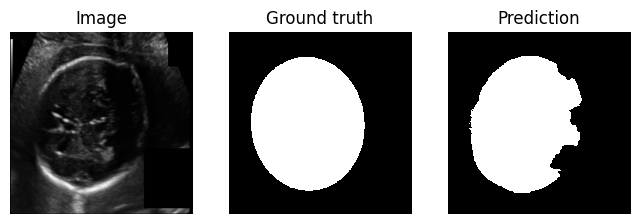

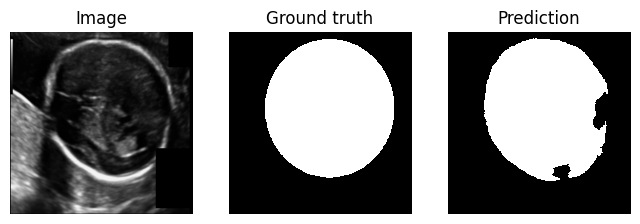

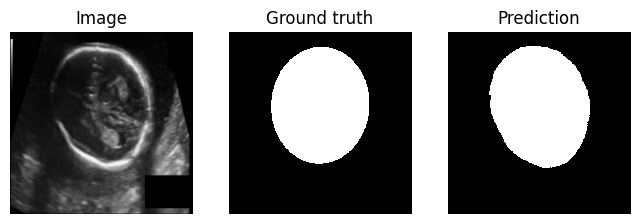

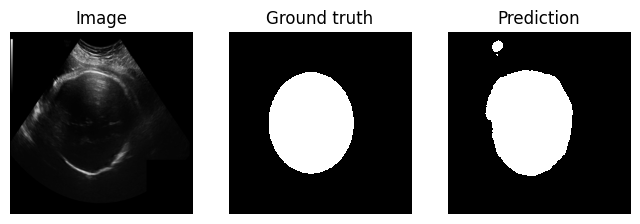

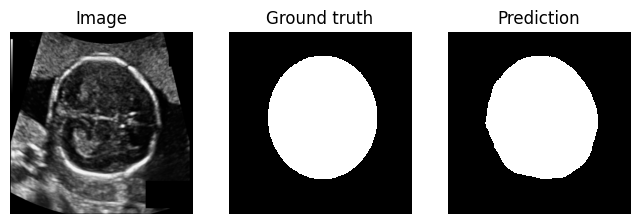

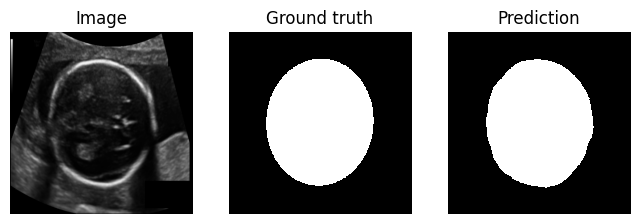

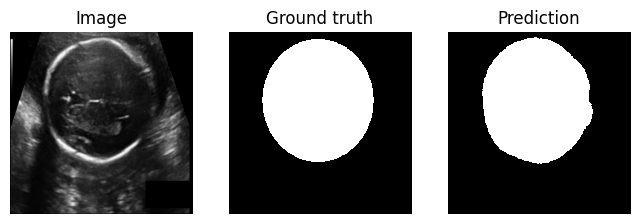

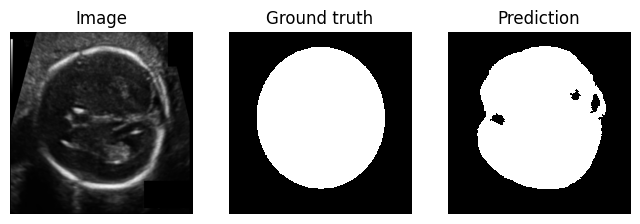

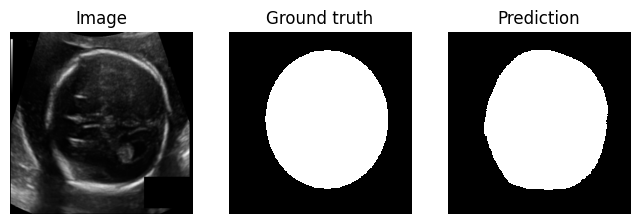

In [ ]:
with torch.no_grad():
  for x, y in testloader_subset:
    image = x.to(DEVICE)
    gt_mask = y.to(DEVICE).unsqueeze(1)
    preds = model(image)
    preds = preds[0]
    preds = (preds > 0.5).float()

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 3, 1)
    x = x.flatten(0, 1)
    plt.imshow(x.permute(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(1-y.numpy().squeeze(),cmap='Greys',interpolation='nearest') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(1-preds.cpu().data.numpy().squeeze(),cmap='Greys',interpolation='nearest') # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()